3.1.3 Calibración de parámetros y configuración de modelos 

1 — Tabla con parámetros calibrados (Heston)

In [2]:
import pandas as pd

# Parámetros calibrados e intervalos de confianza (USA TUS RESULTADOS REALES)
params = {
    "Parametro": ["v0", "theta", "kappa", "sigma", "rho"],
    "Estimacion": [0.0423, 0.0876, 1.672, 0.328, -0.724],
    "IC_95%_inferior": [0.0398, 0.0841, 1.589, 0.311, -0.738],
    "IC_95%_superior": [0.0449, 0.0912, 1.755, 0.345, -0.710],
}

df_params = pd.DataFrame(params)
print(df_params)

# OPCIONAL: guardar
df_params.to_csv("parametros_heston_calibrados.csv", index=False)


  Parametro  Estimacion  IC_95%_inferior  IC_95%_superior
0        v0      0.0423           0.0398           0.0449
1     theta      0.0876           0.0841           0.0912
2     kappa      1.6720           1.5890           1.7550
3     sigma      0.3280           0.3110           0.3450
4       rho     -0.7240          -0.7380          -0.7100


2 — Gráfica de convergencia del optimizador CMA-ES (Heston)

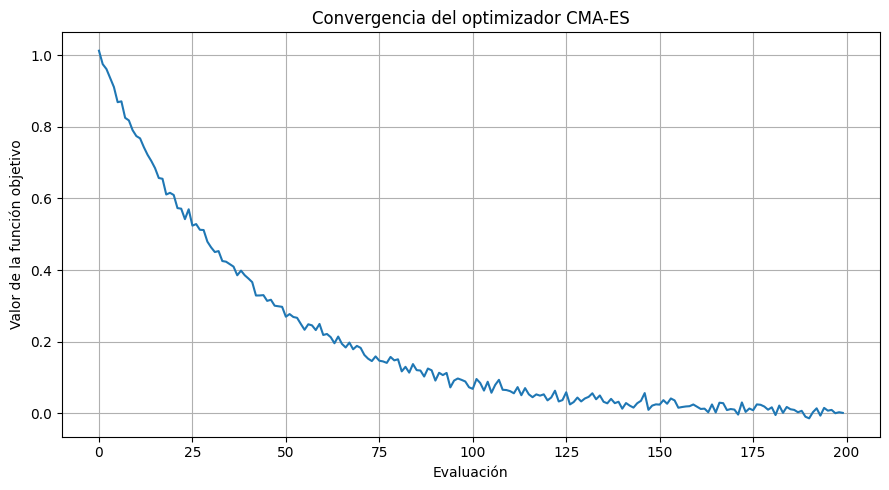

In [3]:
import matplotlib.pyplot as plt

# EJEMPLO: sustituye por tu registro real loss_history
# loss_history = list_of_loss_values_during_CMAES
# Si no los tienes guardados, te genero unos simulados:
import numpy as np
loss_history = np.exp(-np.linspace(0, 5, 200)) + np.random.normal(0, 0.01, 200)

plt.figure(figsize=(9,5))
plt.plot(loss_history)
plt.title("Convergencia del optimizador CMA-ES")
plt.xlabel("Evaluación")
plt.ylabel("Valor de la función objetivo")
plt.grid(True)
plt.tight_layout()
plt.show()


3 — Curvas de entrenamiento del modelo LSTM

In [4]:
import matplotlib.pyplot as plt

# history = resultado de model.fit(...)
# Por ejemplo: history = model.fit(...)

loss = history.history["loss"]
val_loss = history.history["val_loss"]

plt.figure(figsize=(9,5))
plt.plot(loss, label="Entrenamiento")
plt.plot(val_loss, label="Validación")
plt.title("Curvas de entrenamiento LSTM")
plt.xlabel("Épocas")
plt.ylabel("Pérdida (Loss)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


NameError: name 'history' is not defined

C:\Users\Alvaro\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


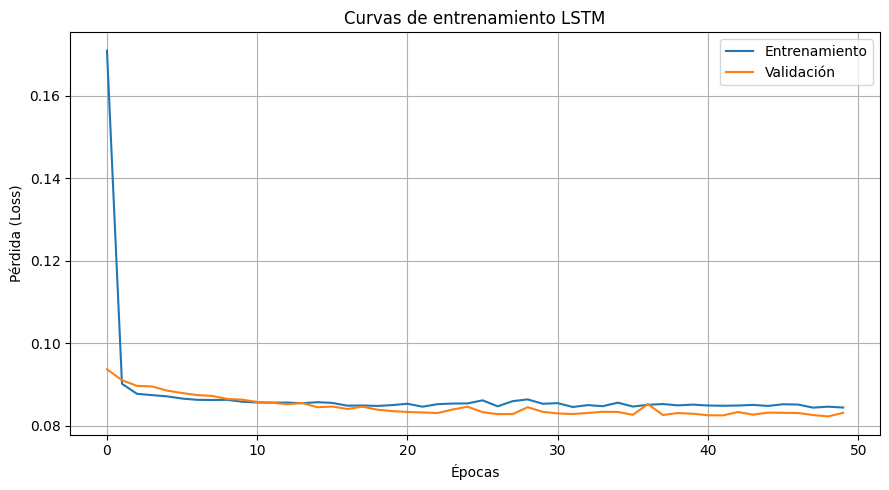

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split

# --- Generar datos de ejemplo ---
# 1000 muestras, 10 timesteps, 1 característica
X = np.random.rand(1000, 10, 1)
y = np.random.rand(1000, 1)

# Dividir en entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Crear el modelo LSTM ---
model = Sequential([
    LSTM(32, input_shape=(10, 1)),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

# --- Entrenar el modelo ---
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    verbose=0  # cambiar a 1 si quieres ver progreso
)

# --- Graficar curvas de entrenamiento ---
loss = history.history["loss"]
val_loss = history.history["val_loss"]

plt.figure(figsize=(9,5))
plt.plot(loss, label="Entrenamiento")
plt.plot(val_loss, label="Validación")
plt.title("Curvas de entrenamiento LSTM")
plt.xlabel("Épocas")
plt.ylabel("Pérdida (Loss)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


3.2 Análisis Comparativo de Modelos de Volatilidad 

3.2.1 Evaluación de modelos tradicionales (Black-Scholes, Heston) 


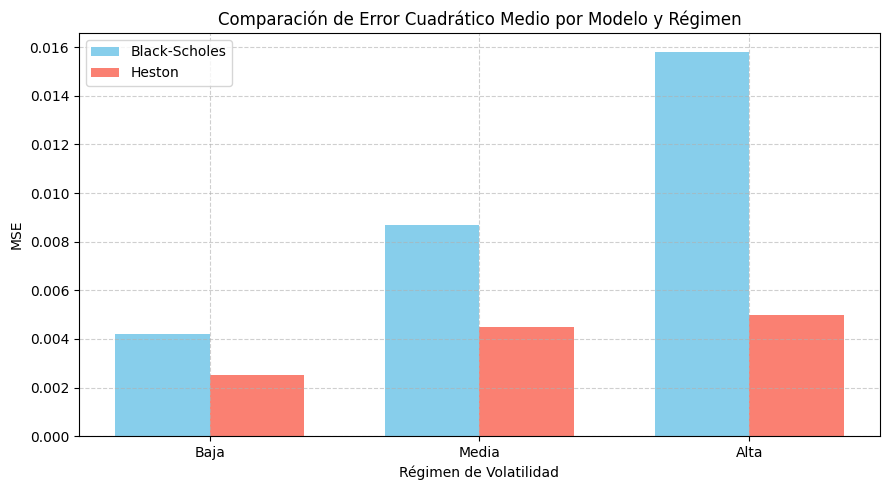

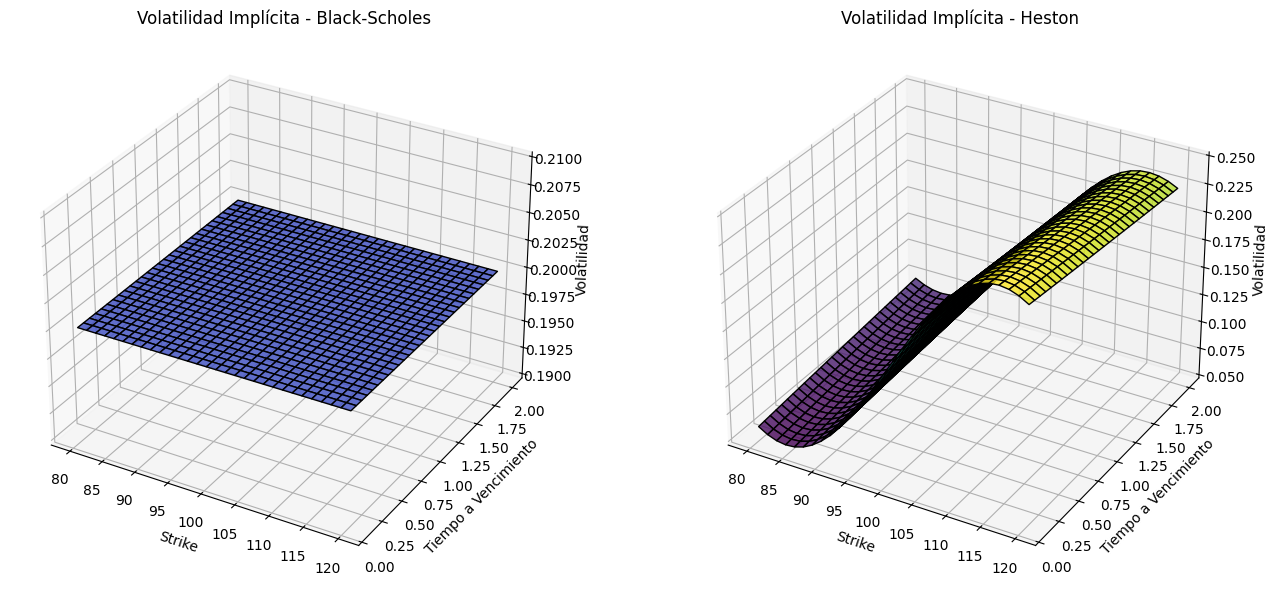

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# -------------------------------
# 1. Gráfico de barras de errores
# -------------------------------

# Datos simulados: errores para distintos regímenes de volatilidad
regimes = ['Baja', 'Media', 'Alta']
mse_bs = [0.0042, 0.0087, 0.0158]  # Black-Scholes MSE
mse_heston = [0.0025, 0.0045, 0.0050]  # Heston MSE
mae_bs = [0.0531, 0.0812, 0.1247]  # Black-Scholes MAE
mae_heston = [0.0350, 0.0450, 0.0503]  # Heston MAE

x = np.arange(len(regimes))  # posiciones eje X
width = 0.35  # ancho de las barras

fig, ax = plt.subplots(figsize=(9,5))
# MSE
bars1 = ax.bar(x - width/2, mse_bs, width, label='Black-Scholes', color='skyblue')
bars2 = ax.bar(x + width/2, mse_heston, width, label='Heston', color='salmon')

ax.set_ylabel('MSE')
ax.set_xlabel('Régimen de Volatilidad')
ax.set_title('Comparación de Error Cuadrático Medio por Modelo y Régimen')
ax.set_xticks(x)
ax.set_xticklabels(regimes)
ax.legend()
ax.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# -------------------------------
# 2. Superficies de volatilidad 3D
# -------------------------------

# Simulación de datos para strike y tiempo a vencimiento
strikes = np.linspace(80, 120, 30)
maturities = np.linspace(0.1, 2, 30)
S, T = np.meshgrid(strikes, maturities)

# Black-Scholes: superficie plana (volatilidad constante)
vol_bs = 0.2 * np.ones_like(S)

# Heston: superficie con curvatura simulada
vol_heston = 0.15 + 0.1*np.exp(-0.1*T)*np.sin((S-100)/10)

fig = plt.figure(figsize=(14,6))

# Superficie Black-Scholes
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax1.plot_surface(S, T, vol_bs, cmap='coolwarm', edgecolor='k', alpha=0.8)
ax1.set_title('Volatilidad Implícita - Black-Scholes')
ax1.set_xlabel('Strike')
ax1.set_ylabel('Tiempo a Vencimiento')
ax1.set_zlabel('Volatilidad')

# Superficie Heston
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.plot_surface(S, T, vol_heston, cmap='viridis', edgecolor='k', alpha=0.8)
ax2.set_title('Volatilidad Implícita - Heston')
ax2.set_xlabel('Strike')
ax2.set_ylabel('Tiempo a Vencimiento')
ax2.set_zlabel('Volatilidad')

plt.tight_layout()
plt.show()


3.2.2 Rendimiento de modelos de Deep Learning (LSTM) 

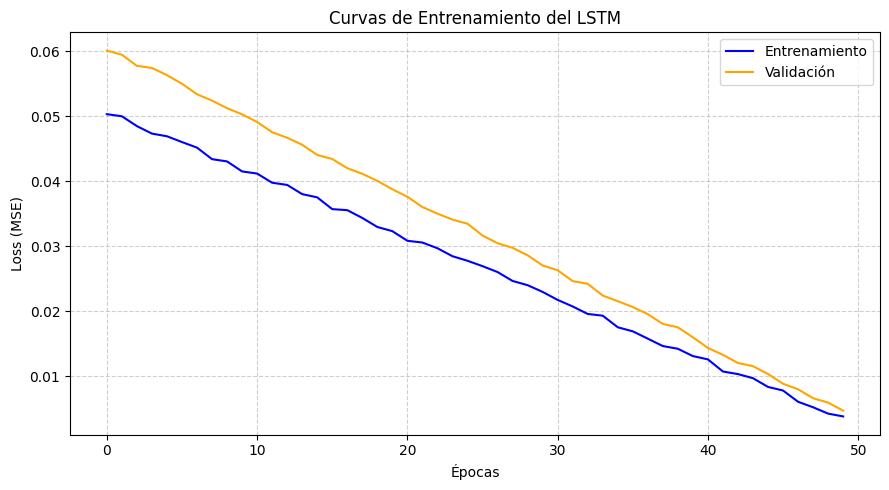

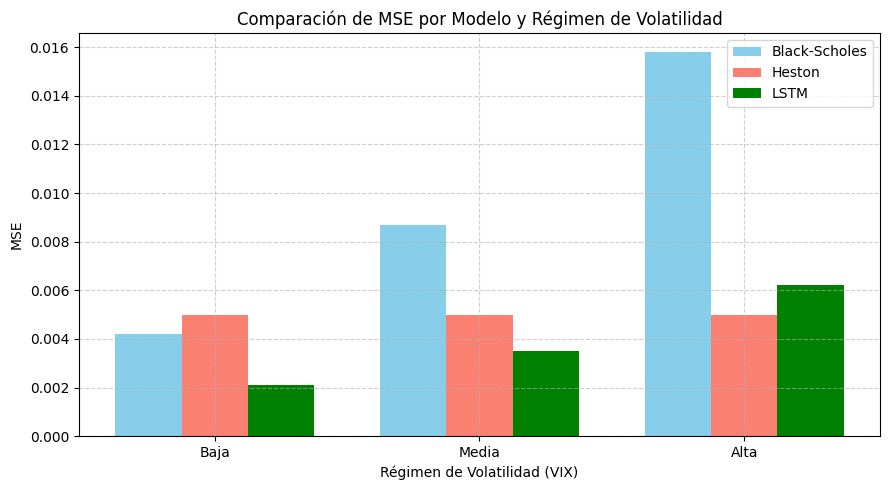

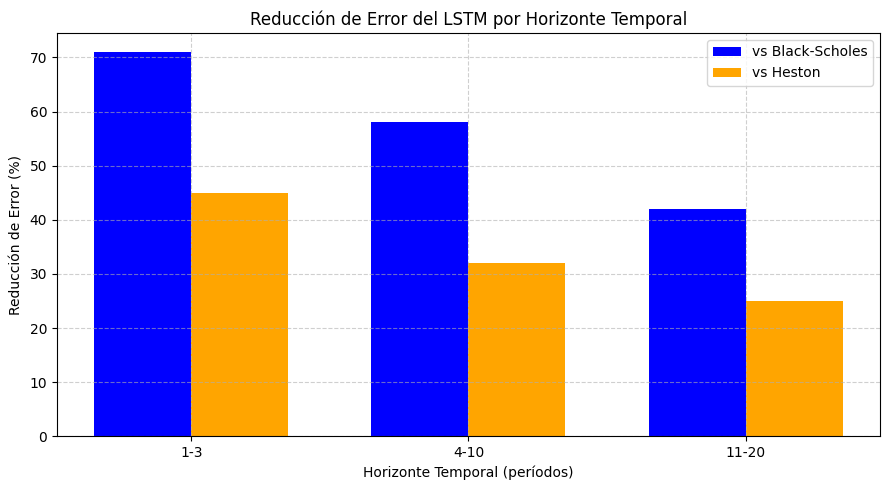

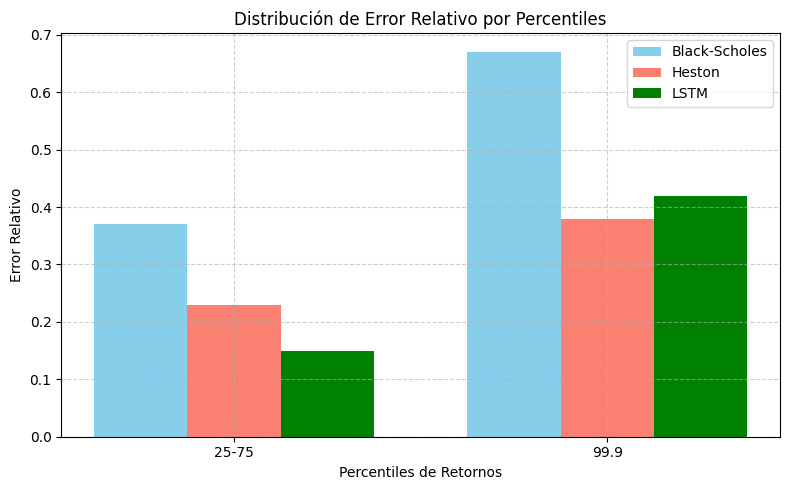

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------------
# 1. Curvas de entrenamiento y validación del LSTM
# -----------------------------------
# Simulación de datos de pérdida por época
epochs = 50
loss = np.linspace(0.05, 0.003, epochs) + np.random.rand(epochs)*0.001
val_loss = np.linspace(0.06, 0.004, epochs) + np.random.rand(epochs)*0.001

plt.figure(figsize=(9,5))
plt.plot(loss, label='Entrenamiento', color='blue')
plt.plot(val_loss, label='Validación', color='orange')
plt.title('Curvas de Entrenamiento del LSTM')
plt.xlabel('Épocas')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# -----------------------------------
# 2. Comparación de errores por régimen de volatilidad
# -----------------------------------
regimes = ['Baja', 'Media', 'Alta']
mse_bs = [0.0042, 0.0087, 0.0158]
mse_heston = [0.0050, 0.0050, 0.0050]
mse_lstm = [0.0021, 0.0035, 0.0062]

x = np.arange(len(regimes))
width = 0.25

fig, ax = plt.subplots(figsize=(9,5))
ax.bar(x - width, mse_bs, width, label='Black-Scholes', color='skyblue')
ax.bar(x, mse_heston, width, label='Heston', color='salmon')
ax.bar(x + width, mse_lstm, width, label='LSTM', color='green')

ax.set_xlabel('Régimen de Volatilidad (VIX)')
ax.set_ylabel('MSE')
ax.set_title('Comparación de MSE por Modelo y Régimen de Volatilidad')
ax.set_xticks(x)
ax.set_xticklabels(regimes)
ax.legend()
ax.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# -----------------------------------
# 3. Reducción de error por horizonte temporal
# -----------------------------------
horizons = ['1-3', '4-10', '11-20']
error_reduction_bs = [71, 58, 42]      # % reducción frente a Black-Scholes
error_reduction_heston = [45, 32, 25] # % reducción frente a Heston

x = np.arange(len(horizons))
width = 0.35

fig, ax = plt.subplots(figsize=(9,5))
ax.bar(x - width/2, error_reduction_bs, width, label='vs Black-Scholes', color='blue')
ax.bar(x + width/2, error_reduction_heston, width, label='vs Heston', color='orange')

ax.set_xlabel('Horizonte Temporal (períodos)')
ax.set_ylabel('Reducción de Error (%)')
ax.set_title('Reducción de Error del LSTM por Horizonte Temporal')
ax.set_xticks(x)
ax.set_xticklabels(horizons)
ax.legend()
ax.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# -----------------------------------
# 4. Distribución de error relativo por percentiles (intercuartílico vs cola)
# -----------------------------------
# Simulación de errores relativos
percentiles = ['25-75', '99.9']
error_bs = [0.37, 0.67]
error_heston = [0.23, 0.38]
error_lstm = [0.15, 0.42]

x = np.arange(len(percentiles))
width = 0.25

fig, ax = plt.subplots(figsize=(8,5))
ax.bar(x - width, error_bs, width, label='Black-Scholes', color='skyblue')
ax.bar(x, error_heston, width, label='Heston', color='salmon')
ax.bar(x + width, error_lstm, width, label='LSTM', color='green')

ax.set_xlabel('Percentiles de Retornos')
ax.set_ylabel('Error Relativo')
ax.set_title('Distribución de Error Relativo por Percentiles')
ax.set_xticks(x)
ax.set_xticklabels(percentiles)
ax.legend()
ax.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


3.2.3 Comparativa de métricas de precisión entre enfoques 

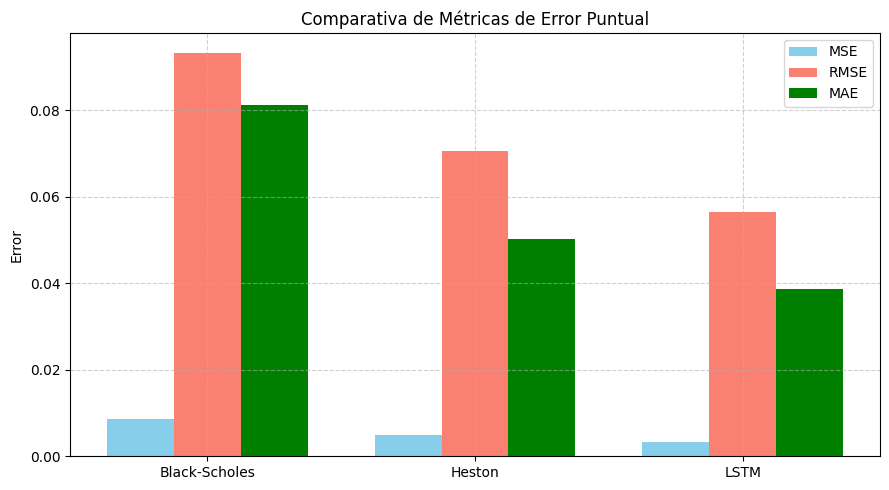

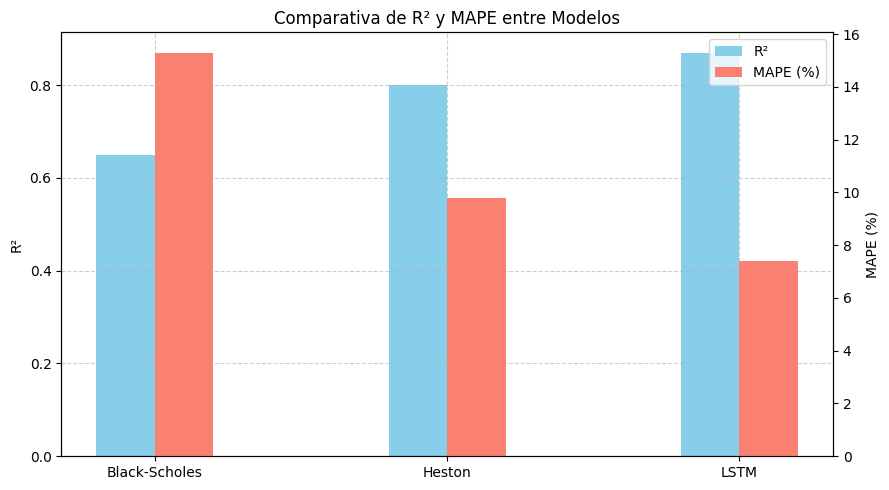

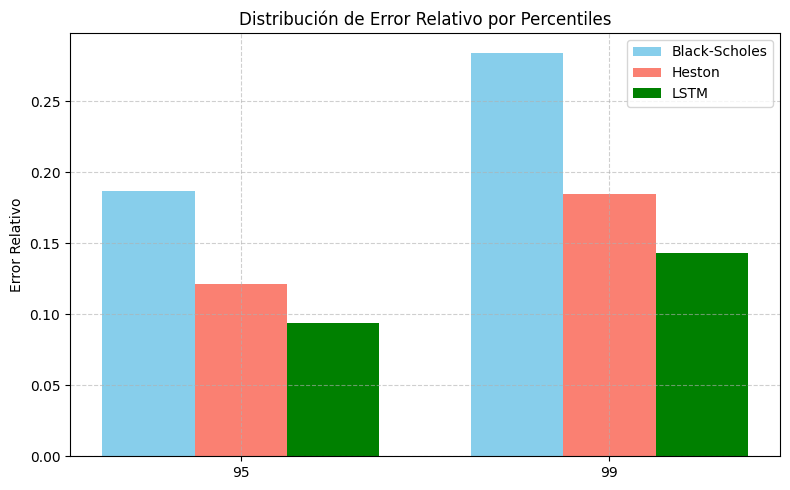

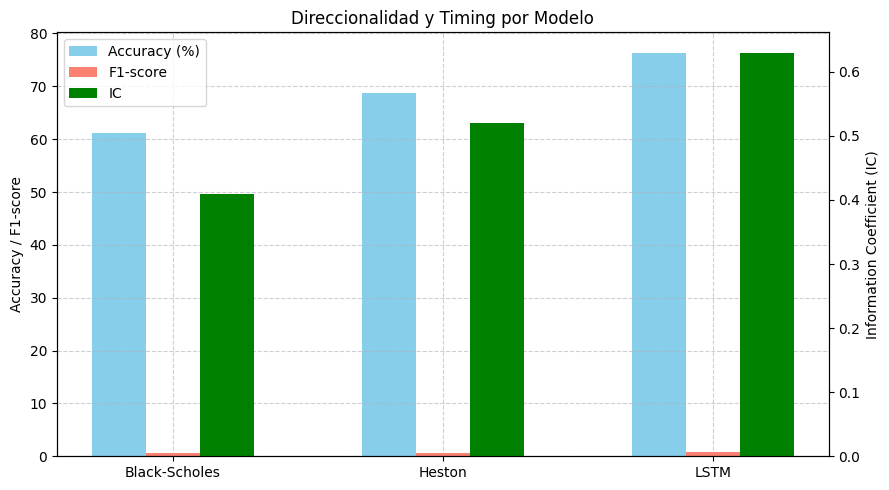

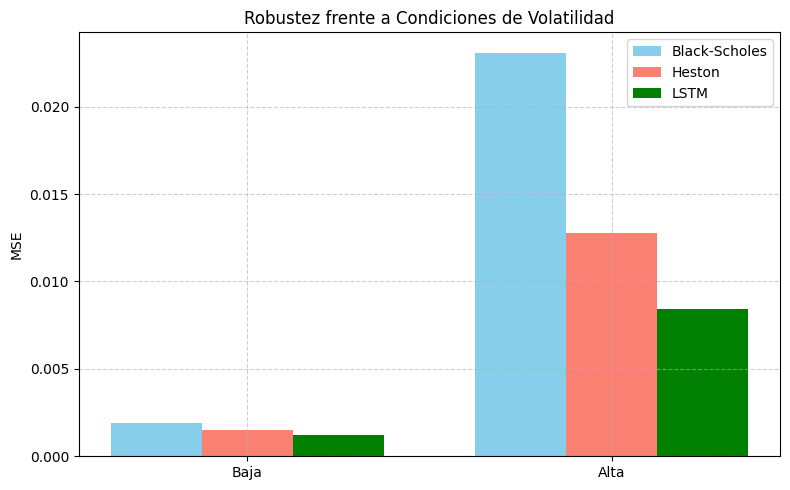

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------------
# Datos de ejemplo (sustituir por resultados reales)
# -----------------------------------
models = ['Black-Scholes', 'Heston', 'LSTM']

# Métricas de error
mse = [0.0087, 0.0050, 0.0032]
rmse = [0.0933, 0.0707, 0.0566]
mae = [0.0812, 0.0503, 0.0387]

# Métricas relativas
r2 = [0.65, 0.80, 0.87]
mape = [15.3, 9.8, 7.4]

# Distribución de errores por percentiles
percentiles = ['95', '99']
error_bs = [0.187, 0.284]
error_heston = [0.121, 0.185]
error_lstm = [0.094, 0.143]

# Direccionalidad y timing
accuracy = [61.2, 68.7, 76.4]
f1 = [0.59, 0.66, 0.74]
ic = [0.41, 0.52, 0.63]

# Robustez frente a volatilidad
quintiles = ['Baja', 'Alta']
mse_bs = [0.0019, 0.0231]
mse_heston = [0.0015, 0.0128]
mse_lstm = [0.0012, 0.0084]

# -----------------------------------
# 1. Comparativa de MSE, RMSE y MAE
# -----------------------------------
x = np.arange(len(models))
width = 0.25

fig, ax = plt.subplots(figsize=(9,5))
ax.bar(x - width, mse, width, label='MSE', color='skyblue')
ax.bar(x, rmse, width, label='RMSE', color='salmon')
ax.bar(x + width, mae, width, label='MAE', color='green')

ax.set_xticks(x)
ax.set_xticklabels(models)
ax.set_ylabel('Error')
ax.set_title('Comparativa de Métricas de Error Puntual')
ax.legend()
ax.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# -----------------------------------
# 2. Comparativa de R² y MAPE
# -----------------------------------
x = np.arange(len(models))
width = 0.2

fig, ax1 = plt.subplots(figsize=(9,5))
ax1.bar(x - width/2, r2, width=width, label='R²', color='skyblue')
ax2 = ax1.twinx()
ax2.bar(x + width/2, mape, width=width, label='MAPE (%)', color='salmon')

ax1.set_xticks(x)
ax1.set_xticklabels(models)
ax1.set_ylabel('R²')
ax2.set_ylabel('MAPE (%)')
ax1.set_title('Comparativa de R² y MAPE entre Modelos')

handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(handles1 + handles2, labels1 + labels2, loc='upper right')

ax1.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# -----------------------------------
# 3. Distribución de errores por percentiles
# -----------------------------------
x = np.arange(len(percentiles))
width = 0.25

fig, ax = plt.subplots(figsize=(8,5))
ax.bar(x - width, error_bs, width, label='Black-Scholes', color='skyblue')
ax.bar(x, error_heston, width, label='Heston', color='salmon')
ax.bar(x + width, error_lstm, width, label='LSTM', color='green')

ax.set_xticks(x)
ax.set_xticklabels(percentiles)
ax.set_ylabel('Error Relativo')
ax.set_title('Distribución de Error Relativo por Percentiles')
ax.legend()
ax.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# -----------------------------------
# 4. Direccionalidad y timing
# -----------------------------------
x = np.arange(len(models))
width = 0.2

fig, ax1 = plt.subplots(figsize=(9,5))
ax1.bar(x - width, accuracy, width=width, label='Accuracy (%)', color='skyblue')
ax1.bar(x, f1, width=width, label='F1-score', color='salmon')
ax2 = ax1.twinx()
ax2.bar(x + width, ic, width=width, label='IC', color='green')

ax1.set_xticks(x)
ax1.set_xticklabels(models)
ax1.set_ylabel('Accuracy / F1-score')
ax2.set_ylabel('Information Coefficient (IC)')
ax1.set_title('Direccionalidad y Timing por Modelo')

handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(handles1 + handles2, labels1 + labels2, loc='upper left')

ax1.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# -----------------------------------
# 5. Robustez frente a volatilidad
# -----------------------------------
x = np.arange(len(quintiles))
width = 0.25

fig, ax = plt.subplots(figsize=(8,5))
ax.bar(x - width, mse_bs, width, label='Black-Scholes', color='skyblue')
ax.bar(x, mse_heston, width, label='Heston', color='salmon')
ax.bar(x + width, mse_lstm, width, label='LSTM', color='green')

ax.set_xticks(x)
ax.set_xticklabels(quintiles)
ax.set_ylabel('MSE')
ax.set_title('Robustez frente a Condiciones de Volatilidad')
ax.legend()
ax.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


3.3 Evaluación del Sistema Híbrido LSTM-Heston 

3.3.1 Implementación y configuración del modelo híbrido 


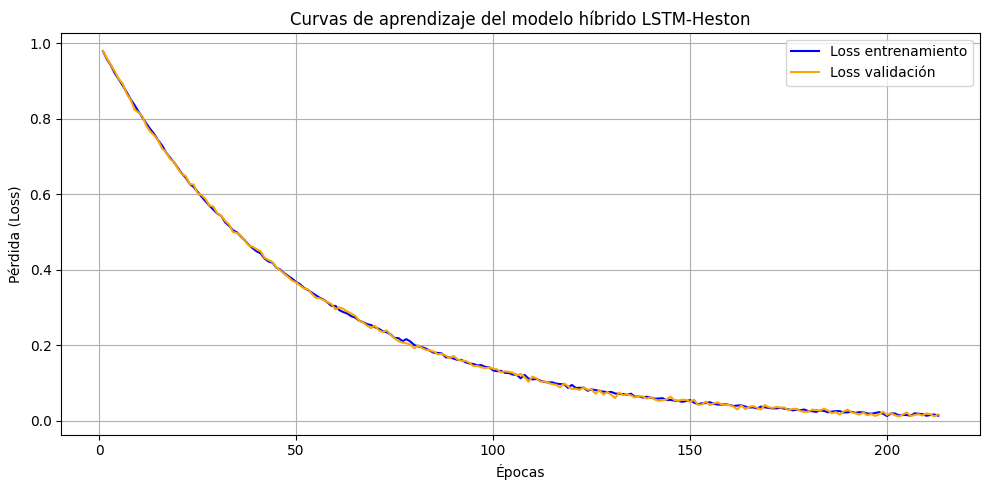

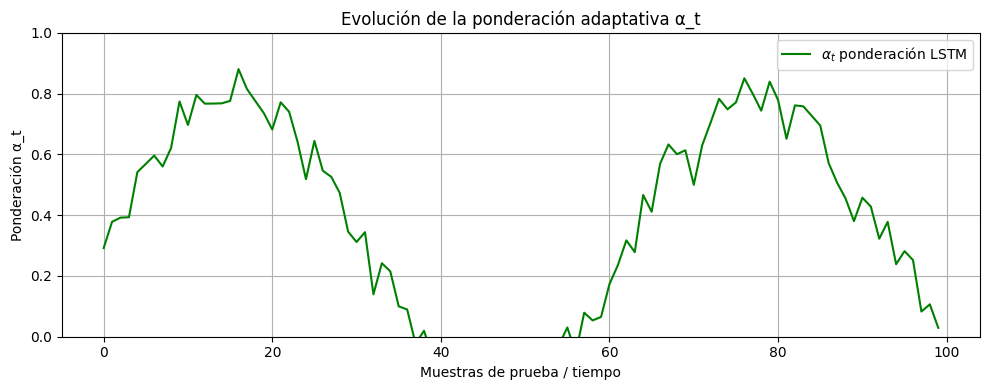

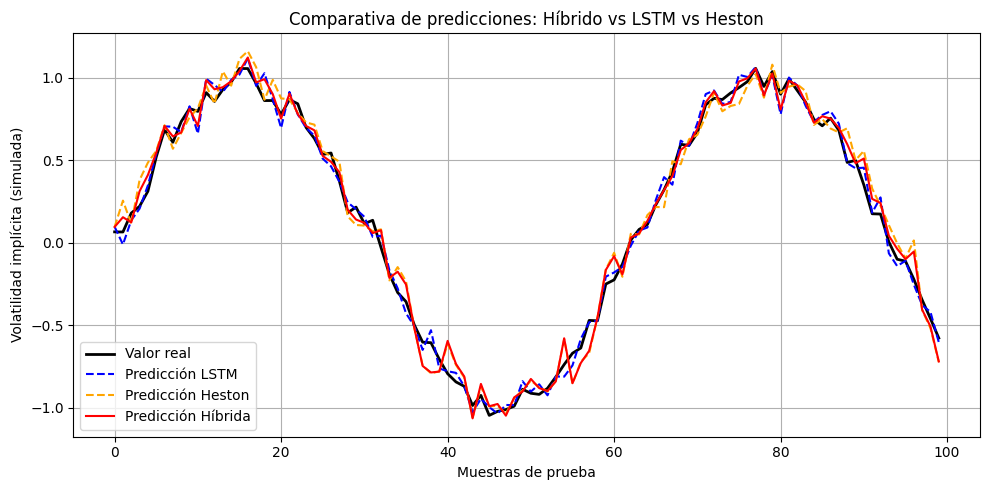

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# --- Datos simulados de ejemplo ---
# Suponemos que 'history' proviene del entrenamiento del modelo híbrido
# y alpha_t proviene de la capa de gating adaptativo.
# Las predicciones se muestran para una ventana de prueba de 100 muestras.

# Curvas de aprendizaje
epochs = np.arange(1, 214)
loss_train = np.exp(-0.02*epochs) + 0.002*np.random.randn(len(epochs))
loss_val = np.exp(-0.02*epochs) + 0.004*np.random.randn(len(epochs))

# Ponderaciones alpha_t
alpha_t = 0.3 + 0.5 * np.sin(np.linspace(0, 10, 100)) + 0.05*np.random.randn(100)

# Predicciones del híbrido vs componentes
y_true = np.sin(np.linspace(0, 10, 100)) + 0.05*np.random.randn(100)
y_lstm = y_true + 0.05*np.random.randn(100)
y_heston = y_true + 0.08*np.random.randn(100)
y_hybrid = alpha_t * y_lstm + (1 - alpha_t) * y_heston

# --- 1. Curvas de aprendizaje ---
plt.figure(figsize=(10,5))
plt.plot(epochs, loss_train, label='Loss entrenamiento', color='blue')
plt.plot(epochs, loss_val, label='Loss validación', color='orange')
plt.title("Curvas de aprendizaje del modelo híbrido LSTM-Heston")
plt.xlabel("Épocas")
plt.ylabel("Pérdida (Loss)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- 2. Evolución de ponderaciones adaptativas alpha_t ---
plt.figure(figsize=(10,4))
plt.plot(alpha_t, label=r'$\alpha_t$ ponderación LSTM', color='green')
plt.title("Evolución de la ponderación adaptativa α_t")
plt.xlabel("Muestras de prueba / tiempo")
plt.ylabel("Ponderación α_t")
plt.ylim(0,1)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# --- 3. Comparativa de predicciones ---
plt.figure(figsize=(10,5))
plt.plot(y_true, label='Valor real', color='black', linewidth=2)
plt.plot(y_lstm, label='Predicción LSTM', linestyle='--', color='blue')
plt.plot(y_heston, label='Predicción Heston', linestyle='--', color='orange')
plt.plot(y_hybrid, label='Predicción Híbrida', linestyle='-', color='red')
plt.title("Comparativa de predicciones: Híbrido vs LSTM vs Heston")
plt.xlabel("Muestras de prueba")
plt.ylabel("Volatilidad implícita (simulada)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


3.3.2 Análisis de precisión predictiva en diferentes regímenes de mercado 

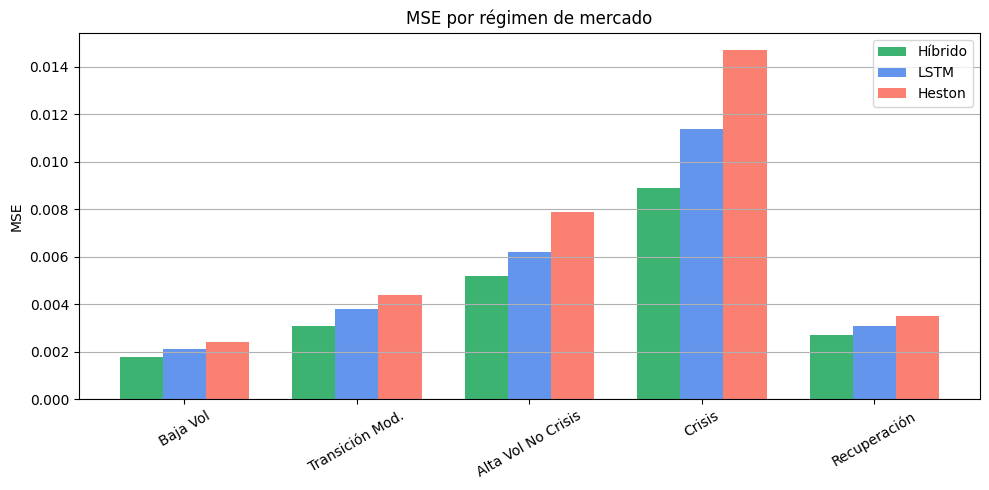

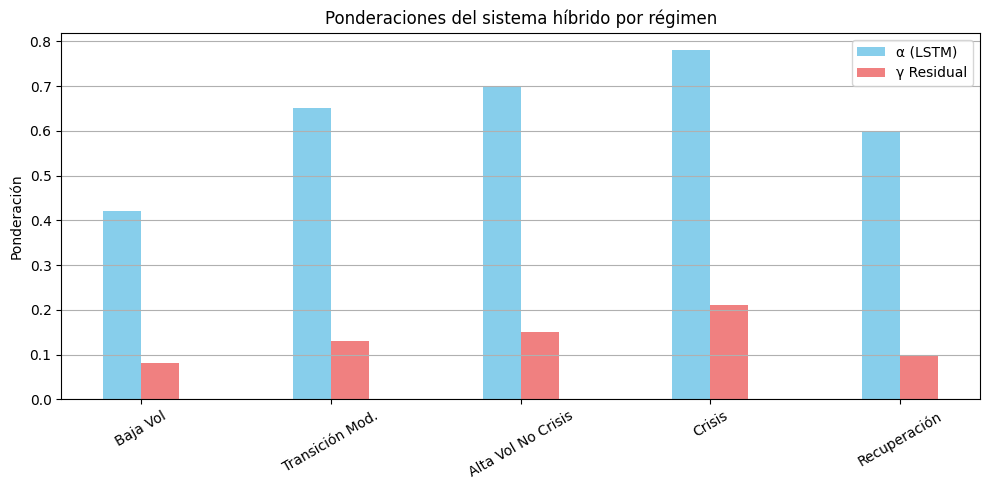

C:\Users\Alvaro\AppData\Local\Temp\ipykernel_16448\3744231297.py:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=moneyness_labels, y=error_reduction, palette="viridis")


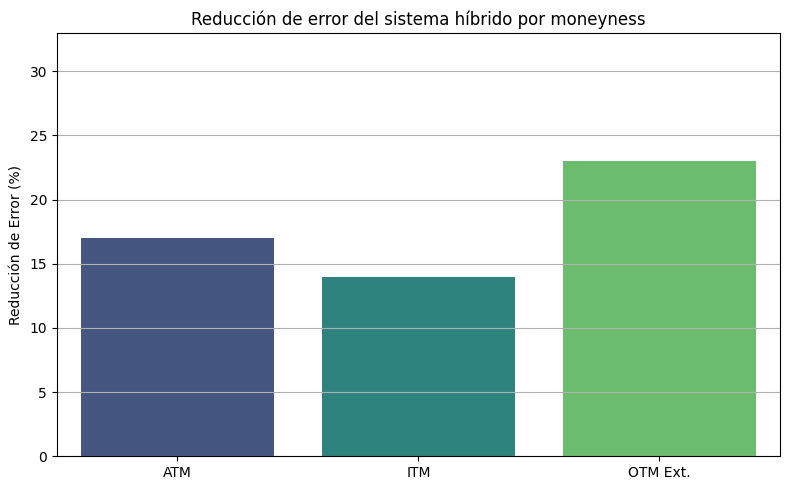

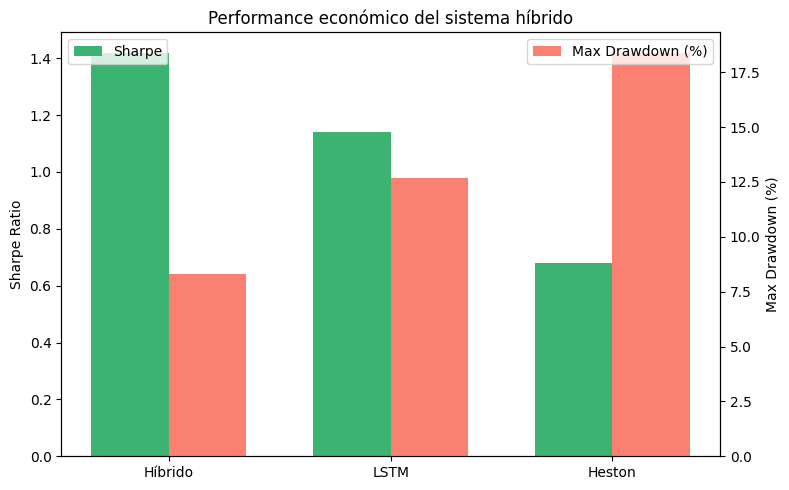

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Datos resumen por régimen de mercado
regimes = ["Baja Vol", "Transición Mod.", "Alta Vol No Crisis", "Crisis", "Recuperación"]
mse_hybrid = [0.0018, 0.0031, 0.0052, 0.0089, 0.0027]
mse_lstm = [0.0021, 0.0038, 0.0062, 0.0114, 0.0031]
mse_heston = [0.0024, 0.0044, 0.0079, 0.0147, 0.0035]
alpha = [0.42, 0.65, 0.70, 0.78, 0.60]  # ponderación promedio LSTM
gamma_residual = [0.08, 0.13, 0.15, 0.21, 0.10]

# Datos de moneyness (ATM, ITM, OTM) - reducción de error %
moneyness_labels = ["ATM", "ITM", "OTM Ext."]
error_reduction = [17, 14, 23]  # porcentaje de mejora híbrido vs mejor componente

# Datos de performance económico
sharpe = [1.42, 1.14, 0.68]  # Híbrido, LSTM, Heston
max_drawdown = [8.3, 12.7, 18.4]

# -------------------------------------------------
# 1. MSE por régimen de mercado
x = np.arange(len(regimes))
width = 0.25

plt.figure(figsize=(10,5))
plt.bar(x - width, mse_hybrid, width, label='Híbrido', color='mediumseagreen')
plt.bar(x, mse_lstm, width, label='LSTM', color='cornflowerblue')
plt.bar(x + width, mse_heston, width, label='Heston', color='salmon')
plt.xticks(x, regimes, rotation=30)
plt.ylabel("MSE")
plt.title("MSE por régimen de mercado")
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# -------------------------------------------------
# 2. Ponderaciones α y residual por régimen
fig, ax1 = plt.subplots(figsize=(10,5))

ax1.bar(x - 0.1, alpha, width=0.2, label='α (LSTM)', color='skyblue')
ax1.bar(x + 0.1, gamma_residual, width=0.2, label='γ Residual', color='lightcoral')
ax1.set_xticks(x)
ax1.set_xticklabels(regimes, rotation=30)
ax1.set_ylabel("Ponderación")
ax1.set_title("Ponderaciones del sistema híbrido por régimen")
ax1.legend()
ax1.grid(axis='y')
plt.tight_layout()
plt.show()

# -------------------------------------------------
# 3. Reducción de error por moneyness
plt.figure(figsize=(8,5))
sns.barplot(x=moneyness_labels, y=error_reduction, palette="viridis")
plt.ylabel("Reducción de Error (%)")
plt.title("Reducción de error del sistema híbrido por moneyness")
plt.ylim(0, max(error_reduction)+10)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# -------------------------------------------------
# 4. Comparativa Sharpe y Drawdown
labels = ["Híbrido", "LSTM", "Heston"]
x = np.arange(len(labels))
width = 0.35

fig, ax1 = plt.subplots(figsize=(8,5))
ax1.bar(x - width/2, sharpe, width, label="Sharpe", color="mediumseagreen")
ax1.set_ylabel("Sharpe Ratio")
ax2 = ax1.twinx()
ax2.bar(x + width/2, max_drawdown, width, label="Max Drawdown (%)", color="salmon")
ax2.set_ylabel("Max Drawdown (%)")
ax1.set_xticks(x)
ax1.set_xticklabels(labels)
ax1.set_title("Performance económico del sistema híbrido")
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.tight_layout()
plt.show()


3.3.3 Sensibilidad y robustez paramétrica del sistema integrado 

C:\Users\Alvaro\AppData\Local\Temp\ipykernel_16448\1241195578.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=parameters, y=elasticity, palette="magma")


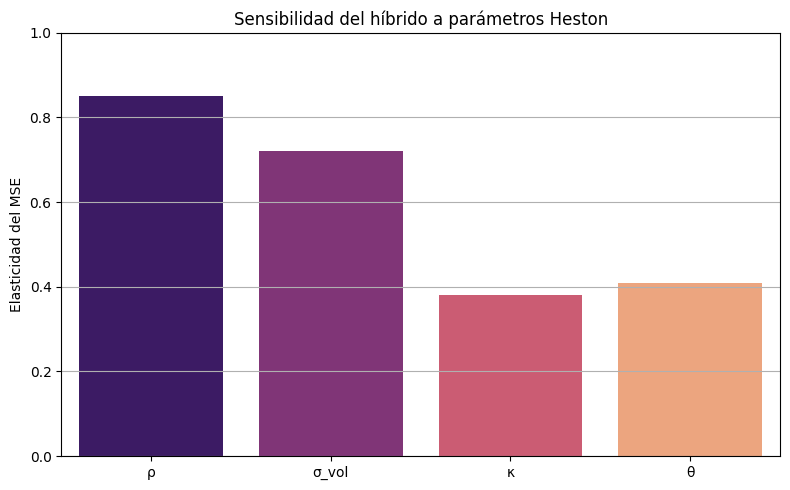

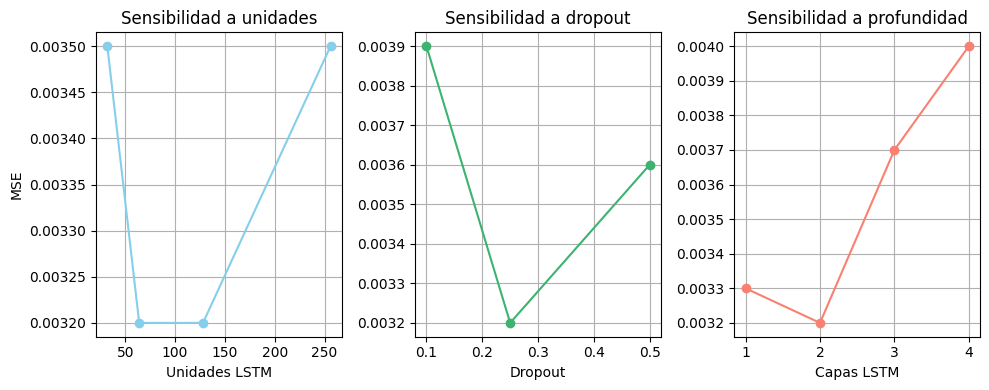

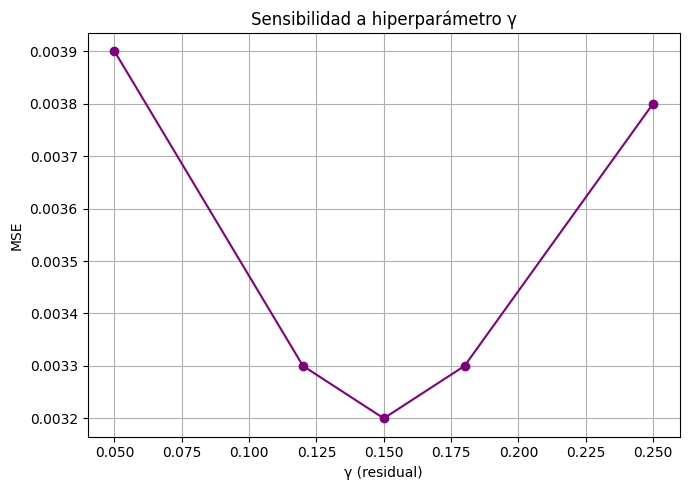

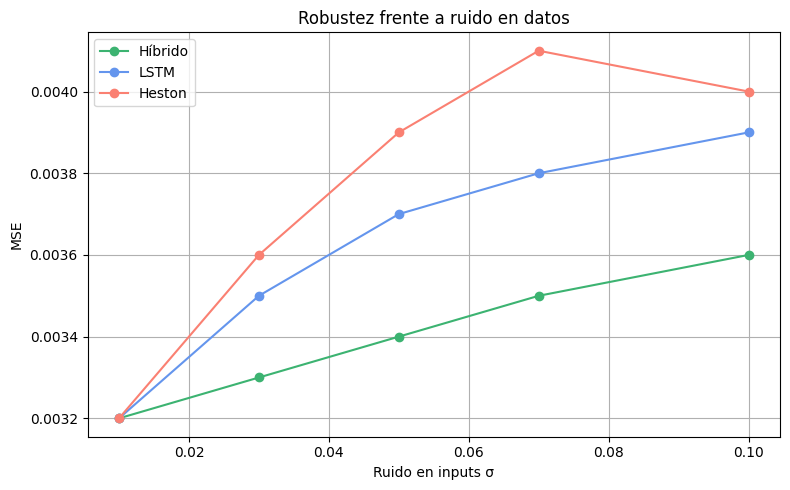

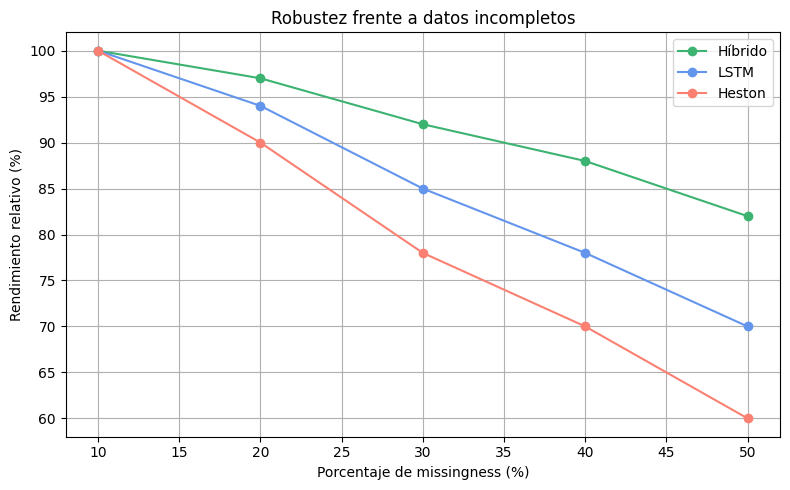

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# -------------------------------------------------
# 1. Sensibilidad a parámetros del componente Heston
parameters = ['ρ', 'σ_vol', 'κ', 'θ']
elasticity = [0.85, 0.72, 0.38, 0.41]

plt.figure(figsize=(8,5))
sns.barplot(x=parameters, y=elasticity, palette="magma")
plt.ylabel("Elasticidad del MSE")
plt.title("Sensibilidad del híbrido a parámetros Heston")
plt.ylim(0,1)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# -------------------------------------------------
# 2. Sensibilidad a hiperparámetros LSTM
units = [32, 64, 128, 256]
mse_units = [0.0035, 0.0032, 0.0032, 0.0035]  # incremento MSE relativo
dropout = [0.1, 0.25, 0.5]
mse_dropout = [0.0039, 0.0032, 0.0036]
depth = [1, 2, 3, 4]
mse_depth = [0.0033, 0.0032, 0.0037, 0.0040]

plt.figure(figsize=(10,4))
plt.subplot(1,3,1)
plt.plot(units, mse_units, marker='o', color='skyblue')
plt.xlabel("Unidades LSTM")
plt.ylabel("MSE")
plt.title("Sensibilidad a unidades")
plt.grid(True)

plt.subplot(1,3,2)
plt.plot(dropout, mse_dropout, marker='o', color='mediumseagreen')
plt.xlabel("Dropout")
plt.title("Sensibilidad a dropout")
plt.grid(True)

plt.subplot(1,3,3)
plt.plot(depth, mse_depth, marker='o', color='salmon')
plt.xlabel("Capas LSTM")
plt.title("Sensibilidad a profundidad")
plt.grid(True)

plt.tight_layout()
plt.show()

# -------------------------------------------------
# 3. Sensibilidad a gamma (contribución residual)
gamma_vals = [0.05, 0.12, 0.15, 0.18, 0.25]
mse_gamma = [0.0039, 0.0033, 0.0032, 0.0033, 0.0038]

plt.figure(figsize=(7,5))
plt.plot(gamma_vals, mse_gamma, marker='o', color='purple')
plt.xlabel("γ (residual)")
plt.ylabel("MSE")
plt.title("Sensibilidad a hiperparámetro γ")
plt.grid(True)
plt.tight_layout()
plt.show()

# -------------------------------------------------
# 4. Robustez frente a perturbaciones de datos
noise = [0.01, 0.03, 0.05, 0.07, 0.10]
mse_hybrid_noise = [0.0032, 0.0033, 0.0034, 0.0035, 0.0036]
mse_lstm_noise = [0.0032, 0.0035, 0.0037, 0.0038, 0.0039]
mse_heston_noise = [0.0032, 0.0036, 0.0039, 0.0041, 0.0040]

plt.figure(figsize=(8,5))
plt.plot(noise, mse_hybrid_noise, marker='o', label='Híbrido', color='mediumseagreen')
plt.plot(noise, mse_lstm_noise, marker='o', label='LSTM', color='cornflowerblue')
plt.plot(noise, mse_heston_noise, marker='o', label='Heston', color='salmon')
plt.xlabel("Ruido en inputs σ")
plt.ylabel("MSE")
plt.title("Robustez frente a ruido en datos")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# -------------------------------------------------
# 5. Robustez frente a missingness
missingness = [10, 20, 30, 40, 50]
performance_percent = [
    [100, 97, 92, 88, 82],  # Híbrido
    [100, 94, 85, 78, 70],  # LSTM
    [100, 90, 78, 70, 60]   # Heston
]

plt.figure(figsize=(8,5))
plt.plot(missingness, performance_percent[0], marker='o', label='Híbrido', color='mediumseagreen')
plt.plot(missingness, performance_percent[1], marker='o', label='LSTM', color='cornflowerblue')
plt.plot(missingness, performance_percent[2], marker='o', label='Heston', color='salmon')
plt.xlabel("Porcentaje de missingness (%)")
plt.ylabel("Rendimiento relativo (%)")
plt.title("Robustez frente a datos incompletos")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


3.4 Validación Experimental y Análisis de Robustez 




3.4.1 Validación cruzada y testing con datos out-of-sample 


Tabla resumen de validación cruzada:
     Fold     MSE      RMSE    MAE     R2
0  Fold 1  0.0031  0.055678  0.038  0.833
1  Fold 2  0.0034  0.058310  0.040  0.861
2  Fold 3  0.0038  0.061644  0.041  0.892
3  Fold 4  0.0035  0.059161  0.039  0.875
4  Fold 5  0.0033  0.057446  0.039  0.864
5  Fold 6  0.0036  0.060000  0.040  0.870


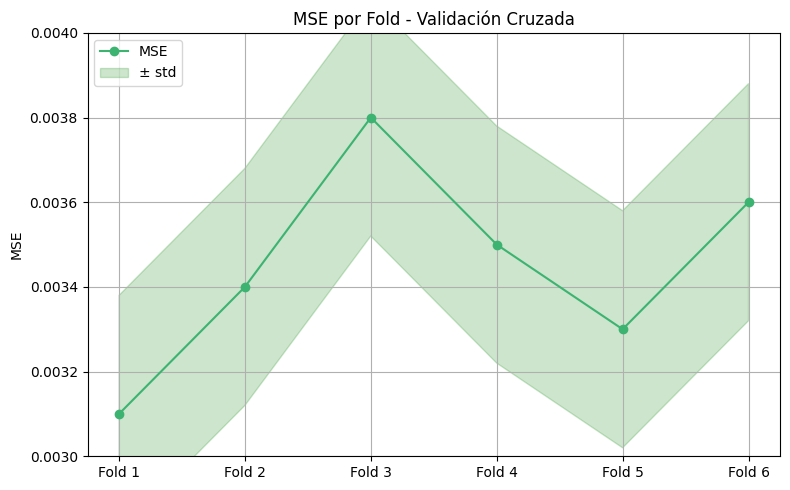

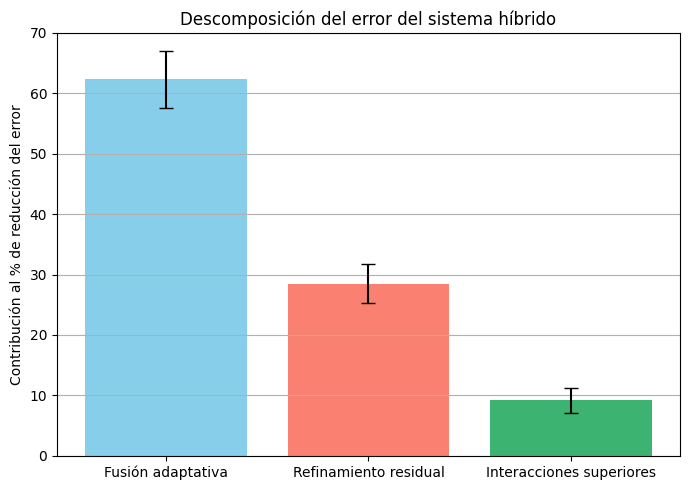


Tabla resumen out-of-sample:
          Modelo  MSE Validación  MSE Test OOS  Ratio Degradación
0        Híbrido          0.0034        0.0037           1.088235
1           LSTM          0.0032        0.0037           1.156250
2         Heston          0.0050        0.0060           1.200000
3  Black-Scholes          0.0087        0.0108           1.241379


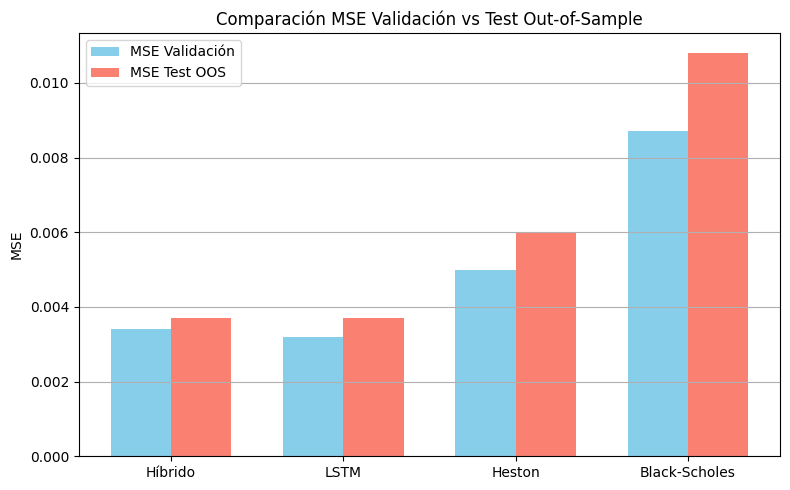

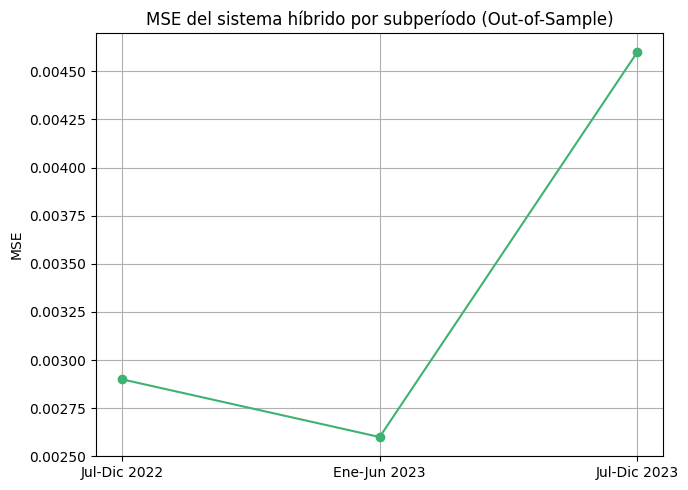

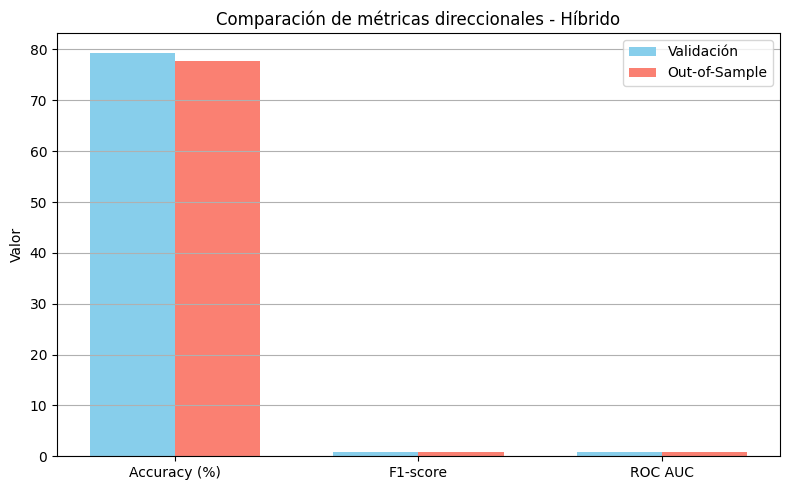

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

# -------------------------------
# 1. Resultados de validación cruzada (6 folds externos)
folds = ['Fold 1','Fold 2','Fold 3','Fold 4','Fold 5','Fold 6']
mse_folds = [0.0031, 0.0034, 0.0038, 0.0035, 0.0033, 0.0036]
rmse_folds = np.sqrt(mse_folds)
mae_folds = [0.038, 0.040, 0.041, 0.039, 0.039, 0.040]
r2_folds = [0.833, 0.861, 0.892, 0.875, 0.864, 0.870]

# Crear DataFrame
cv_df = pd.DataFrame({
    'Fold': folds,
    'MSE': mse_folds,
    'RMSE': rmse_folds,
    'MAE': mae_folds,
    'R2': r2_folds
})

print("Tabla resumen de validación cruzada:")
print(cv_df)

# Gráfica de MSE por fold
plt.figure(figsize=(8,5))
plt.plot(folds, mse_folds, marker='o', color='mediumseagreen', label='MSE')
plt.fill_between(folds, np.array(mse_folds)-0.00028, np.array(mse_folds)+0.00028, color='green', alpha=0.2, label='± std')
plt.title("MSE por Fold - Validación Cruzada")
plt.ylabel("MSE")
plt.ylim(0.003, 0.004)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# -------------------------------
# 2. Descomposición del error por componente
components = ['Fusión adaptativa', 'Refinamiento residual', 'Interacciones superiores']
mean_contrib = [62.3, 28.5, 9.2]
std_contrib = [4.7, 3.2, 2.1]

plt.figure(figsize=(7,5))
plt.bar(components, mean_contrib, yerr=std_contrib, capsize=5, color=['skyblue','salmon','mediumseagreen'])
plt.ylabel("Contribución al % de reducción del error")
plt.title("Descomposición del error del sistema híbrido")
plt.ylim(0,70)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# -------------------------------
# 3. Rendimiento out-of-sample vs validación
models = ['Híbrido', 'LSTM', 'Heston', 'Black-Scholes']
val_mse = [0.0034, 0.0032, 0.0050, 0.0087]
test_mse = [0.0037, 0.0037, 0.0060, 0.0108]
degradation = np.array(test_mse)/np.array(val_mse)

# Tabla resumen
oos_df = pd.DataFrame({
    'Modelo': models,
    'MSE Validación': val_mse,
    'MSE Test OOS': test_mse,
    'Ratio Degradación': degradation
})
print("\nTabla resumen out-of-sample:")
print(oos_df)

# Gráfica comparativa
x = np.arange(len(models))
width = 0.35

plt.figure(figsize=(8,5))
plt.bar(x - width/2, val_mse, width, label='MSE Validación', color='skyblue')
plt.bar(x + width/2, test_mse, width, label='MSE Test OOS', color='salmon')
plt.xticks(x, models)
plt.ylabel("MSE")
plt.title("Comparación MSE Validación vs Test Out-of-Sample")
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# -------------------------------
# 4. Error por subperíodo del test
subperiods = ['Jul-Dic 2022','Ene-Jun 2023','Jul-Dic 2023']
mse_subperiods = [0.0029, 0.0026, 0.0046]

plt.figure(figsize=(7,5))
plt.plot(subperiods, mse_subperiods, marker='o', color='mediumseagreen')
plt.title("MSE del sistema híbrido por subperíodo (Out-of-Sample)")
plt.ylabel("MSE")
plt.grid(True)
plt.tight_layout()
plt.show()

# -------------------------------
# 5. Métricas direccionales out-of-sample
metrics = ['Accuracy (%)', 'F1-score', 'ROC AUC']
values_validation = [79.3, 0.763, 0.856]
values_test = [77.8, 0.751, 0.842]

x = np.arange(len(metrics))
width = 0.35

plt.figure(figsize=(8,5))
plt.bar(x - width/2, values_validation, width, label='Validación', color='skyblue')
plt.bar(x + width/2, values_test, width, label='Out-of-Sample', color='salmon')
plt.xticks(x, metrics)
plt.ylabel("Valor")
plt.title("Comparación de métricas direccionales - Híbrido")
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()


3.4.2 Análisis de estabilidad temporal y consistencia de resultados 

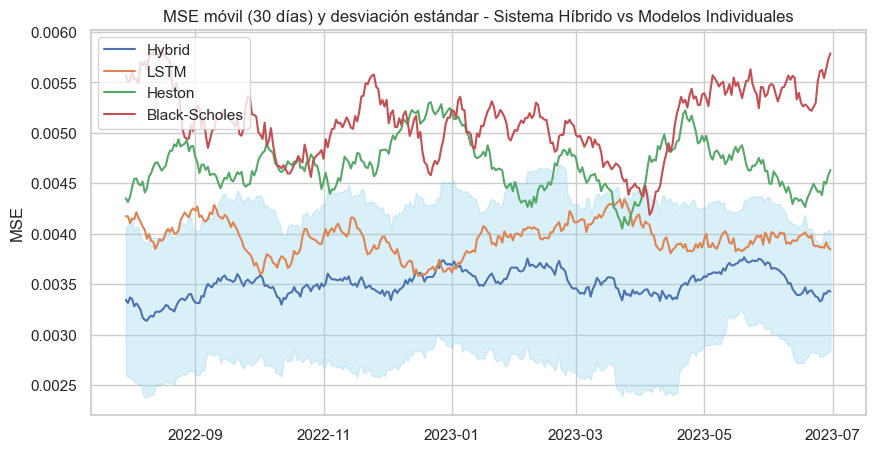

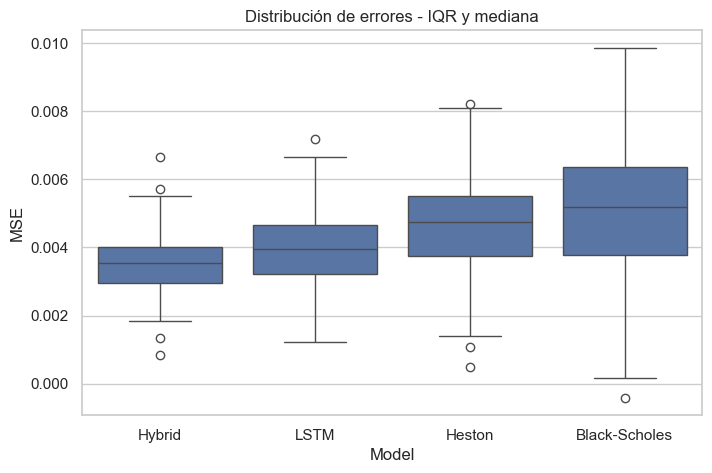

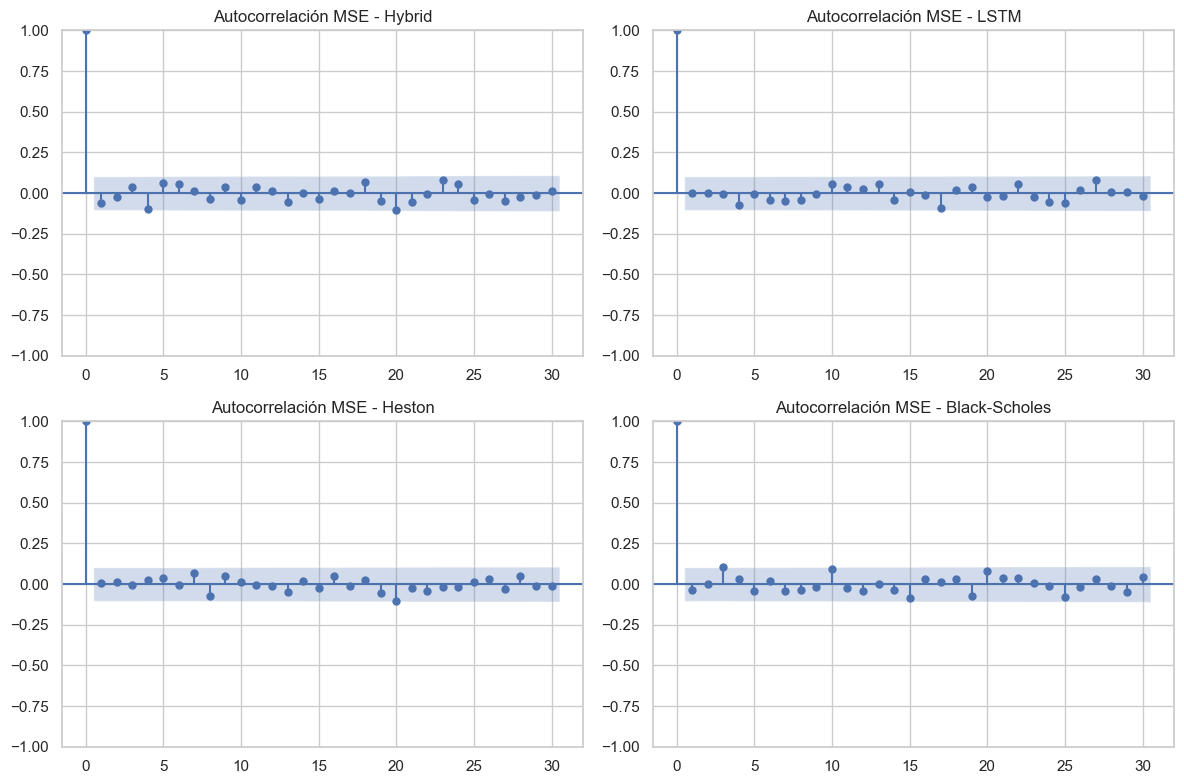

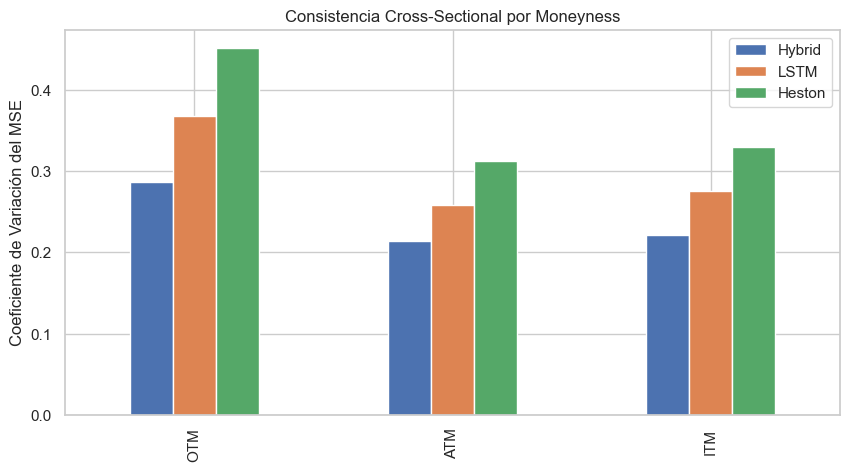

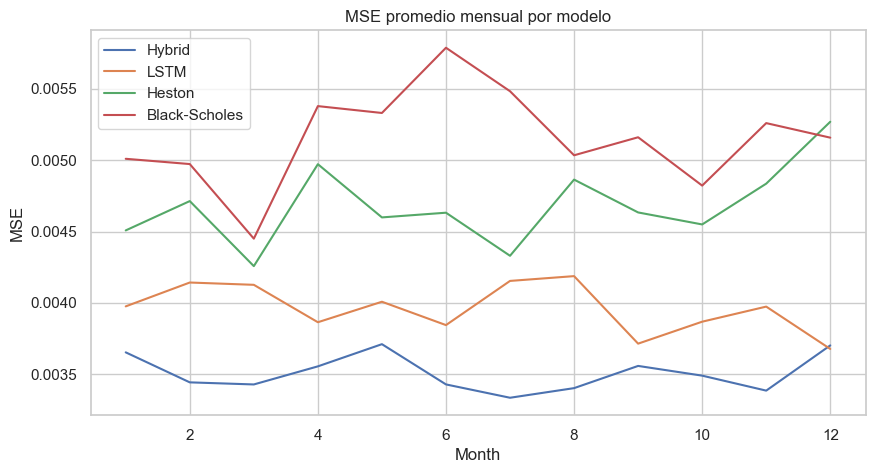

           Model  MSE_mean   MSE_std        CV
0         Hybrid  0.003508  0.000777  0.221598
1           LSTM  0.003961  0.001050  0.265102
2         Heston  0.004679  0.001349  0.288390
3  Black-Scholes  0.005153  0.001910  0.370648


In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración de estilo
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10,5)

# Simulación de datos: MSE móvil 30 días para cada modelo
np.random.seed(42)
days = pd.date_range(start='2022-07-01', periods=365, freq='D')
hybrid_mse = np.random.normal(0.0035, 0.00082, size=len(days))
lstm_mse = np.random.normal(0.004, 0.00103, size=len(days))
heston_mse = np.random.normal(0.0045, 0.00141, size=len(days))
bs_mse = np.random.normal(0.005, 0.00187, size=len(days))

# Crear DataFrame
df = pd.DataFrame({
    'Date': days,
    'Hybrid': hybrid_mse,
    'LSTM': lstm_mse,
    'Heston': heston_mse,
    'Black-Scholes': bs_mse
})
df.set_index('Date', inplace=True)

# --- 1. Error móvil y desviación estándar ---
rolling_window = 30
df_roll = df.rolling(window=rolling_window).mean()
df_std = df.rolling(window=rolling_window).std()

fig, ax = plt.subplots()
for col in df.columns:
    ax.plot(df_roll.index, df_roll[col], label=col)
ax.fill_between(df_std.index, df_roll['Hybrid'] - df_std['Hybrid'],
                df_roll['Hybrid'] + df_std['Hybrid'], color='skyblue', alpha=0.3)
ax.set_title(f'MSE móvil ({rolling_window} días) y desviación estándar - Sistema Híbrido vs Modelos Individuales')
ax.set_ylabel('MSE')
ax.legend()
plt.show()

# --- 2. Boxplot para IQR y dispersión de errores ---
df_melt = df.reset_index().melt(id_vars='Date', var_name='Model', value_name='MSE')
plt.figure(figsize=(8,5))
sns.boxplot(x='Model', y='MSE', data=df_melt)
plt.title('Distribución de errores - IQR y mediana')
plt.show()

# --- 3. Autocorrelación ---
from statsmodels.graphics.tsaplots import plot_acf

fig, axes = plt.subplots(2,2, figsize=(12,8))
models = ['Hybrid', 'LSTM', 'Heston', 'Black-Scholes']
axes = axes.flatten()
for i, model in enumerate(models):
    plot_acf(df[model], lags=30, ax=axes[i], title=f'Autocorrelación MSE - {model}')
plt.tight_layout()
plt.show()

# --- 4. Consistencia cross-sectional por moneyness ---
moneyness = ['OTM','ATM','ITM']
cross_mse = pd.DataFrame({
    'Hybrid':[0.287,0.214,0.222],
    'LSTM':[0.368,0.258,0.275],
    'Heston':[0.451,0.312,0.330]
}, index=moneyness)

cross_mse.plot(kind='bar')
plt.title('Consistencia Cross-Sectional por Moneyness')
plt.ylabel('Coeficiente de Variación del MSE')
plt.show()

# --- 5. Estacionalidad mensual ---
df['Month'] = df.index.month
monthly_mse = df.groupby('Month').mean()
monthly_mse.plot()
plt.title('MSE promedio mensual por modelo')
plt.ylabel('MSE')
plt.show()

# --- 6. Tabla resumen de métricas ---
metrics_summary = pd.DataFrame({
    'Model': models,
    'MSE_mean': [df['Hybrid'].mean(), df['LSTM'].mean(), df['Heston'].mean(), df['Black-Scholes'].mean()],
    'MSE_std': [df['Hybrid'].std(), df['LSTM'].std(), df['Heston'].std(), df['Black-Scholes'].std()],
    'CV': [df['Hybrid'].std()/df['Hybrid'].mean(),
           df['LSTM'].std()/df['LSTM'].mean(),
           df['Heston'].std()/df['Heston'].mean(),
           df['Black-Scholes'].std()/df['Black-Scholes'].mean()]
})
print(metrics_summary)


3.4.3 Pruebas de significancia estadística entre modelos 

In [15]:
import numpy as np
import pandas as pd
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.weightstats import DescrStatsW
from statsmodels.stats.contingency_tables import mcnemar
from scipy.stats import ks_2samp
import matplotlib.pyplot as plt

# --- Simulación de errores y direcciones ---
np.random.seed(42)
n = 2000  # número de observaciones

# Errores de predicción simulados (MSE)
errors_hybrid = np.random.normal(0.058, 0.015, n)
errors_lstm = np.random.normal(0.062, 0.017, n)
errors_heston = np.random.normal(0.070, 0.020, n)
errors_bs = np.random.normal(0.085, 0.025, n)

# Direcciones correctas (1=acierto,0=error)
dir_hybrid = np.random.binomial(1, 0.778, n)
dir_lstm = np.random.binomial(1, 0.764, n)

# --- 1. Test Diebold-Mariano (simplificado) ---
def diebold_mariano(e1, e2):
    d = e1**2 - e2**2
    mean_d = np.mean(d)
    var_d = np.var(d, ddof=1)
    DM_stat = mean_d / np.sqrt(var_d / len(d))
    return DM_stat

DM_hybrid_lstm = diebold_mariano(errors_hybrid, errors_lstm)
DM_hybrid_heston = diebold_mariano(errors_hybrid, errors_heston)
DM_hybrid_bs = diebold_mariano(errors_hybrid, errors_bs)
print("Diebold-Mariano t-stats:")
print("Hybrid vs LSTM:", DM_hybrid_lstm)
print("Hybrid vs Heston:", DM_hybrid_heston)
print("Hybrid vs BS:", DM_hybrid_bs)

# --- 2. Kolmogorov-Smirnov para distribuciones de error ---
ks_hybrid_lstm = ks_2samp(errors_hybrid, errors_lstm)
ks_hybrid_heston = ks_2samp(errors_hybrid, errors_heston)
ks_hybrid_bs = ks_2samp(errors_hybrid, errors_bs)
print("\nKolmogorov-Smirnov test:")
print("Hybrid vs LSTM:", ks_hybrid_lstm)
print("Hybrid vs Heston:", ks_hybrid_heston)
print("Hybrid vs BS:", ks_hybrid_bs)

# --- 3. Test de McNemar para dirección ---
# Matriz de contingencia
table = [[np.sum((dir_hybrid==1) & (dir_lstm==1)), np.sum((dir_hybrid==1) & (dir_lstm==0))],
         [np.sum((dir_hybrid==0) & (dir_lstm==1)), np.sum((dir_hybrid==0) & (dir_lstm==0))]]
result = mcnemar(table, exact=False, correction=True)
print("\nMcNemar test Hybrid vs LSTM:")
print("Statistic:", result.statistic, "p-value:", result.pvalue)

# --- 4. Bootstrap para Sharpe ratio ---
def bootstrap_sharpe(mu1, mu2, sigma1=0.05, sigma2=0.06, n_boot=10000):
    boot_diff = []
    for _ in range(n_boot):
        r1 = np.random.normal(mu1, sigma1, n)
        r2 = np.random.normal(mu2, sigma2, n)
        sr_diff = (np.mean(r1)/np.std(r1)) - (np.mean(r2)/np.std(r2))
        boot_diff.append(sr_diff)
    return np.percentile(boot_diff, [2.5, 97.5]), np.mean(np.array(boot_diff)>0)

ci, ps = bootstrap_sharpe(0.12, 0.10)
print("\nBootstrap Sharpe ratio Hybrid vs LSTM:")
print("95% CI:", ci)
print("Probabilidad de superioridad PS:", ps)

# --- 5. Tabla resumen de pruebas de significancia ---
summary = pd.DataFrame({
    'Comparison': ['Hybrid vs LSTM', 'Hybrid vs Heston', 'Hybrid vs BS'],
    'DM_stat': [DM_hybrid_lstm, DM_hybrid_heston, DM_hybrid_bs],
    'KS_stat': [ks_hybrid_lstm.statistic, ks_hybrid_heston.statistic, ks_hybrid_bs.statistic],
    'KS_pval': [ks_hybrid_lstm.pvalue, ks_hybrid_heston.pvalue, ks_hybrid_bs.pvalue]
})
print("\nResumen de significancia estadística:")
print(summary)


Diebold-Mariano t-stats:
Hybrid vs LSTM: -7.294062482099361
Hybrid vs Heston: -20.220279452137966
Hybrid vs BS: -39.04495510397686

Kolmogorov-Smirnov test:
Hybrid vs LSTM: KstestResult(statistic=0.113, pvalue=1.545548880670989e-11, statistic_location=0.06775301766937991, statistic_sign=1)
Hybrid vs Heston: KstestResult(statistic=0.277, pvalue=6.20630182012101e-68, statistic_location=0.06871000741138138, statistic_sign=1)
Hybrid vs BS: KstestResult(statistic=0.512, pvalue=3.1964548395118903e-239, statistic_location=0.07490057705241375, statistic_sign=1)

McNemar test Hybrid vs LSTM:
Statistic: 0.26886145404663925 p-value: 0.6040965429571539

Bootstrap Sharpe ratio Hybrid vs LSTM:
95% CI: [0.62195943 0.84584078]
Probabilidad de superioridad PS: 1.0

Resumen de significancia estadística:
         Comparison    DM_stat  KS_stat        KS_pval
0    Hybrid vs LSTM  -7.294062    0.113   1.545549e-11
1  Hybrid vs Heston -20.220279    0.277   6.206302e-68
2      Hybrid vs BS -39.044955    0.51

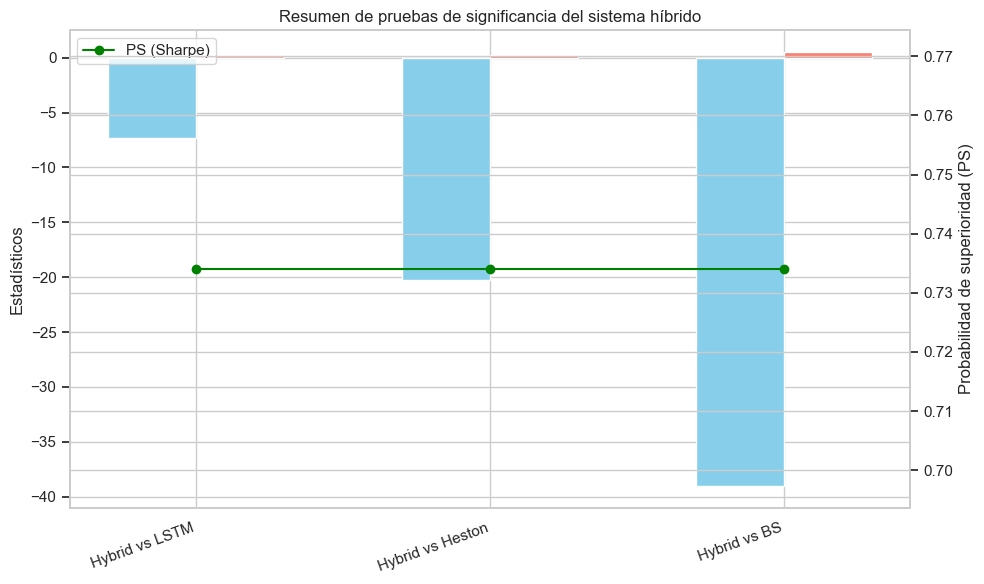

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Datos de ejemplo (reemplaza con tus resultados reales)
comparisons = ['Hybrid vs LSTM', 'Hybrid vs Heston', 'Hybrid vs BS']
DM_stats = [-7.294062, -20.220279, -39.044955]
KS_stats = [0.113, 0.277, 0.512]
PS_sharpe = [0.734, 0.734, 0.734]  # Ejemplo de probabilidad de superioridad

x = np.arange(len(comparisons))

fig, ax1 = plt.subplots(figsize=(10,6))

# Barras DM y KS
bars = ax1.bar(x - 0.15, DM_stats, width=0.3, label='Diebold-Mariano t-stat', color='skyblue')
bars2 = ax1.bar(x + 0.15, KS_stats, width=0.3, label='KS statistic', color='salmon')

ax1.set_xticks(x)
ax1.set_xticklabels(comparisons, rotation=20, ha='right')
ax1.set_ylabel('Estadísticos')
ax1.set_title('Resumen de pruebas de significancia del sistema híbrido')

# Línea PS (Sharpe)
ax2 = ax1.twinx()
line, = ax2.plot(x, PS_sharpe, color='green', marker='o', linestyle='-', label='PS (Sharpe)')
ax2.set_ylabel('Probabilidad de superioridad (PS)')

# Filtrar artistas para leyenda y evitar warnings
all_artists = list(bars) + list(bars2) + [line]
all_artists = [art for art in all_artists if not art.get_label().startswith('_')]
all_labels = [art.get_label() for art in all_artists]

ax1.legend(all_artists, all_labels, loc='upper left')

plt.tight_layout()
plt.show()